In [32]:
from bayesianSimpleViT import BayesianSimpleViT
from bayesianViT import BayesianViT
import torch
from torchvision import transforms, datasets
import numpy as np
from tqdm import tqdm, trange
import sklearn
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

import torch.nn as nn
import torchbnn as bnn

from torch.utils.data.dataloader import default_collate


from bayesianLinformer import BayesianLinformer
from linformer import Linformer

efficient_transformer = BayesianLinformer(
    dim=256,
    seq_len=16+1,  # 4x4 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64,              
    dropout=0.1
)

model = BayesianViT(
    dim=256,
    image_size=28,
    patch_size=7,
    num_classes=10,
    transformer=efficient_transformer,
    channels=1,
)

model.load_state_dict(torch.load('bigBayesianViTmodel.pth'))
model = model.cuda() if torch.cuda.is_available() else model
model.eval()

BayesianViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=7, p2=7)
    (1): LayerNorm((49,), eps=1e-05, elementwise_affine=True)
    (2): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=49, out_features=256, bias=True)
    (3): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): BayesianLinformer(
    (net): SequentialSequence(
      (layers): ModuleList(
        (0-11): 12 x ModuleList(
          (0): PreNorm(
            (fn): LinformerSelfAttention(
              (to_q): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=256, out_features=256, bias=True)
              (to_k): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=256, out_features=256, bias=True)
              (to_v): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (to_out): BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=2

In [42]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
])

test_dataset = datasets.MNIST(
    root='./dataset/minst/',
    train=False,
    download=False,
    transform=transform
)
print(len(test_dataset))
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    shuffle=False,
    batch_size=len(test_dataset))

print(test_dataset.data.shape)


10000
torch.Size([10000, 28, 28])


In [34]:
n_mc_run = 30
med_prob_thres = 0.35

y_pred_logits_list = torch.zeros(len(test_dataset), 10, n_mc_run)

with torch.no_grad():

      for i in range(n_mc_run):
      
            for test_mini_epoch, data in enumerate(test_loader):

                  x_batch, y_batch = data
                  preds = model(x_batch.cuda())
                  y_pred_logits_list[:, :, i] = torch.reshape(preds, (len(test_dataset), 10))



In [35]:
Y_val = test_dataset.targets.numpy()
y_pred_prob_all = torch.softmax(y_pred_logits_list, dim=1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

idx_valid = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(idx_valid))

idx_invalid = [not any(y) for y in y_pred]
print('Unrecognizable samples:', np.where(idx_invalid)[0])

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(Y_val[idx_valid], np.argmax(y_pred[idx_valid], axis=-1))) / len(Y_val[idx_valid]))

print('Test accuracy on MNIST (unrecognizable samples):',
      sum(np.equal(Y_val[idx_invalid], np.argmax(y_pred[idx_invalid], axis=-1))) / len(Y_val[idx_invalid]))

Number of recognizable samples: 9977
Unrecognizable samples: [ 445  883 1299 1527 1634 1868 1903 2186 2326 2573 2995 3005 3030 3778
 3853 4248 4317 5997 6059 6091 9540 9679 9811]
Test accuracy on MNIST (recognizable samples): 0.9826601182720257
Test accuracy on MNIST (unrecognizable samples): 0.043478260869565216


In [61]:
def plot_pred_hist(y_pred, n_class, n_mc_run, n_bins=30, med_prob_thres=0.2, n_subplot_rows=2, figsize=(25, 10)):
    bins = np.logspace(-n_bins, 0, n_bins+1)
    fig, ax = plt.subplots(n_subplot_rows, n_class // n_subplot_rows + 1, figsize=figsize)
    for i in range(n_subplot_rows):
        for j in range(n_class // n_subplot_rows + 1):
            idx = i * (n_class // n_subplot_rows + 1) + j
            if idx < n_class:
                ax[i, j].hist(y_pred[idx], bins)
                ax[i, j].set_xscale('log')
                ax[i, j].set_ylim([0, n_mc_run])
                ax[i, j].title.set_text("{} (median probability: {:.2f}) ({})".format(str(idx),
                                                                               np.median(y_pred[idx]),
                                                                               str(np.median(y_pred[idx]) >= med_prob_thres)))
            else:
                ax[i, j].axis('off')
    plt.show()
    

True label of the test sample 589: 4


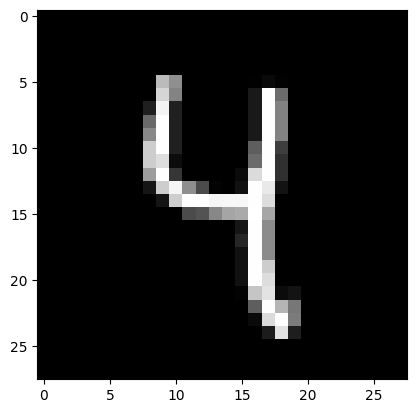

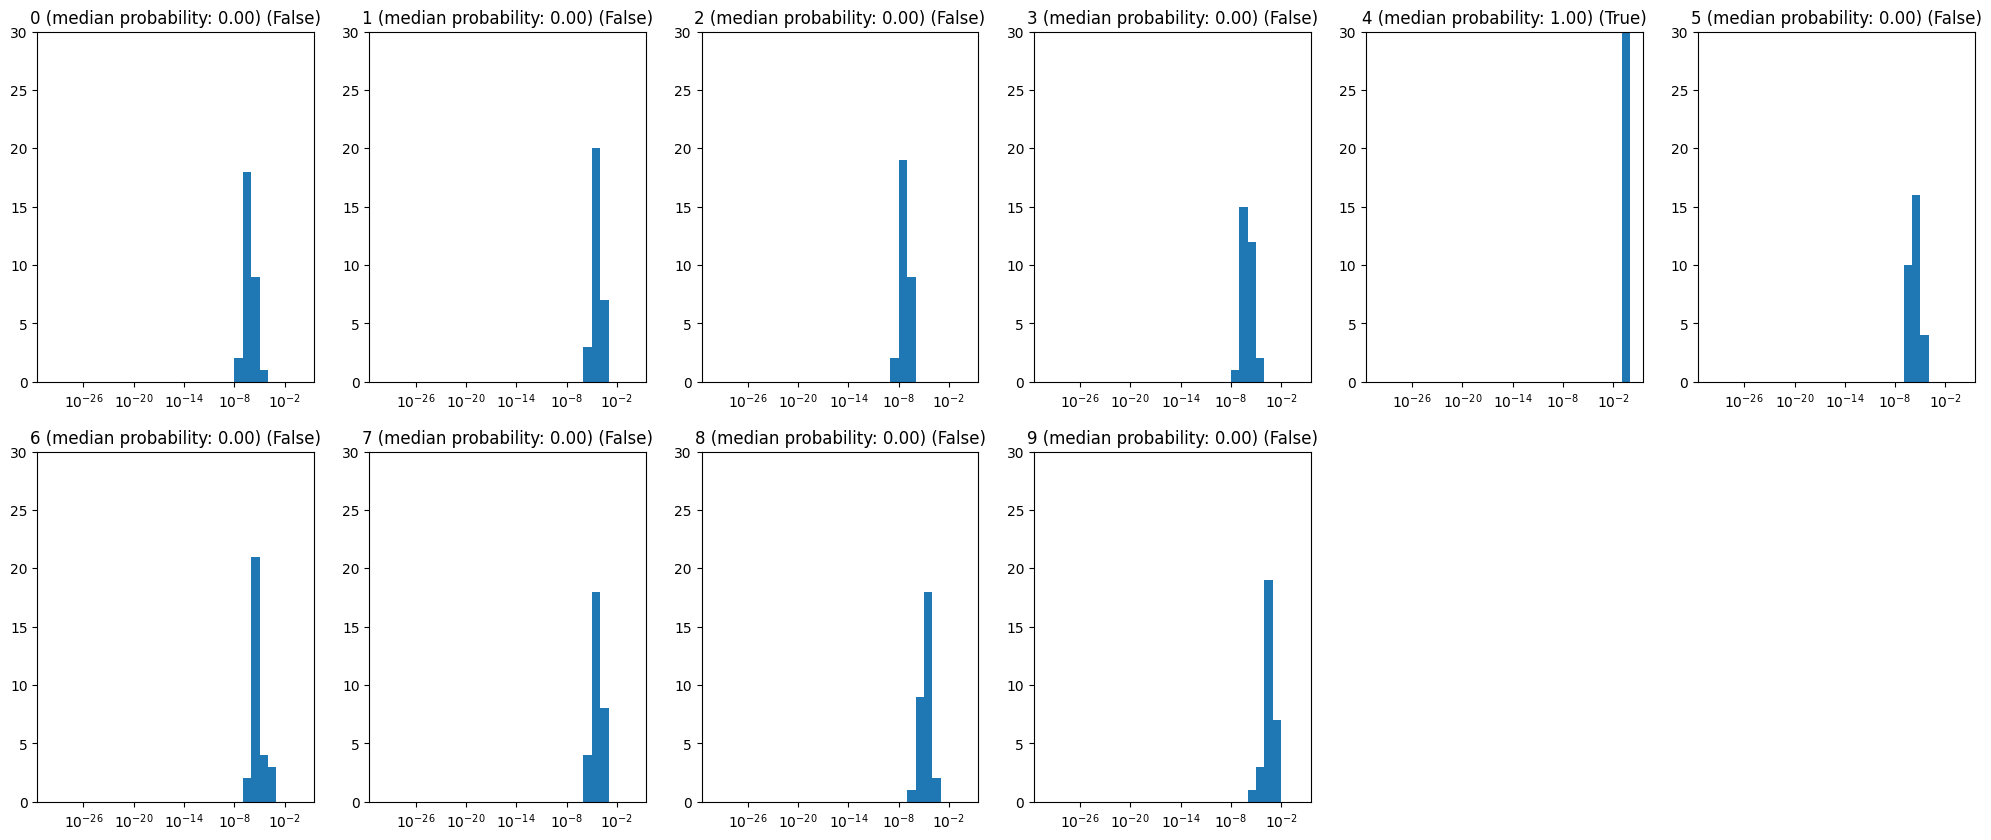

In [46]:
class_nmr = 10
index = 589
plt.imshow(test_dataset.data[index, :, :], cmap='gist_gray')
print("True label of the test sample {}: {}".format(index, Y_val[index]))

plot_pred_hist(y_pred_prob_all[index], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)

True label of the test sample 445: 6


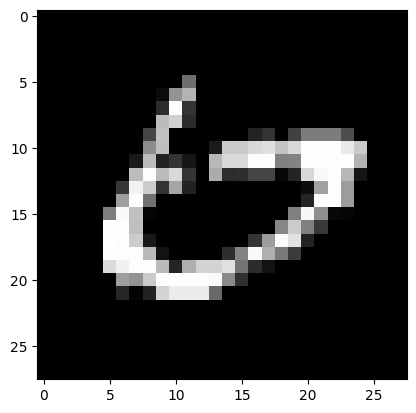

I don't know!
True label of the test sample 883: 3


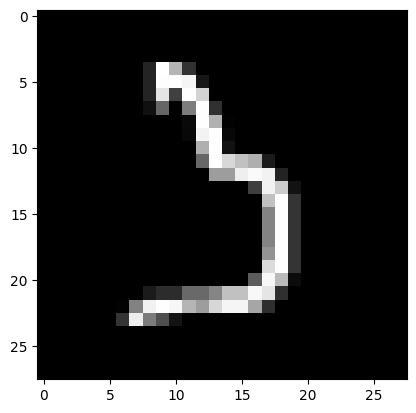

I don't know!
True label of the test sample 1299: 5


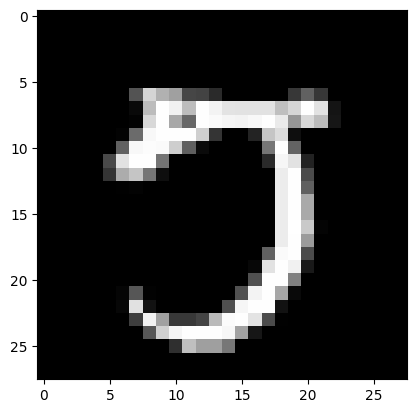

I don't know!
True label of the test sample 1527: 1


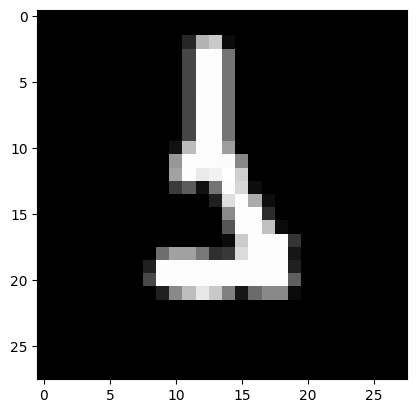

<Figure size 640x480 with 0 Axes>

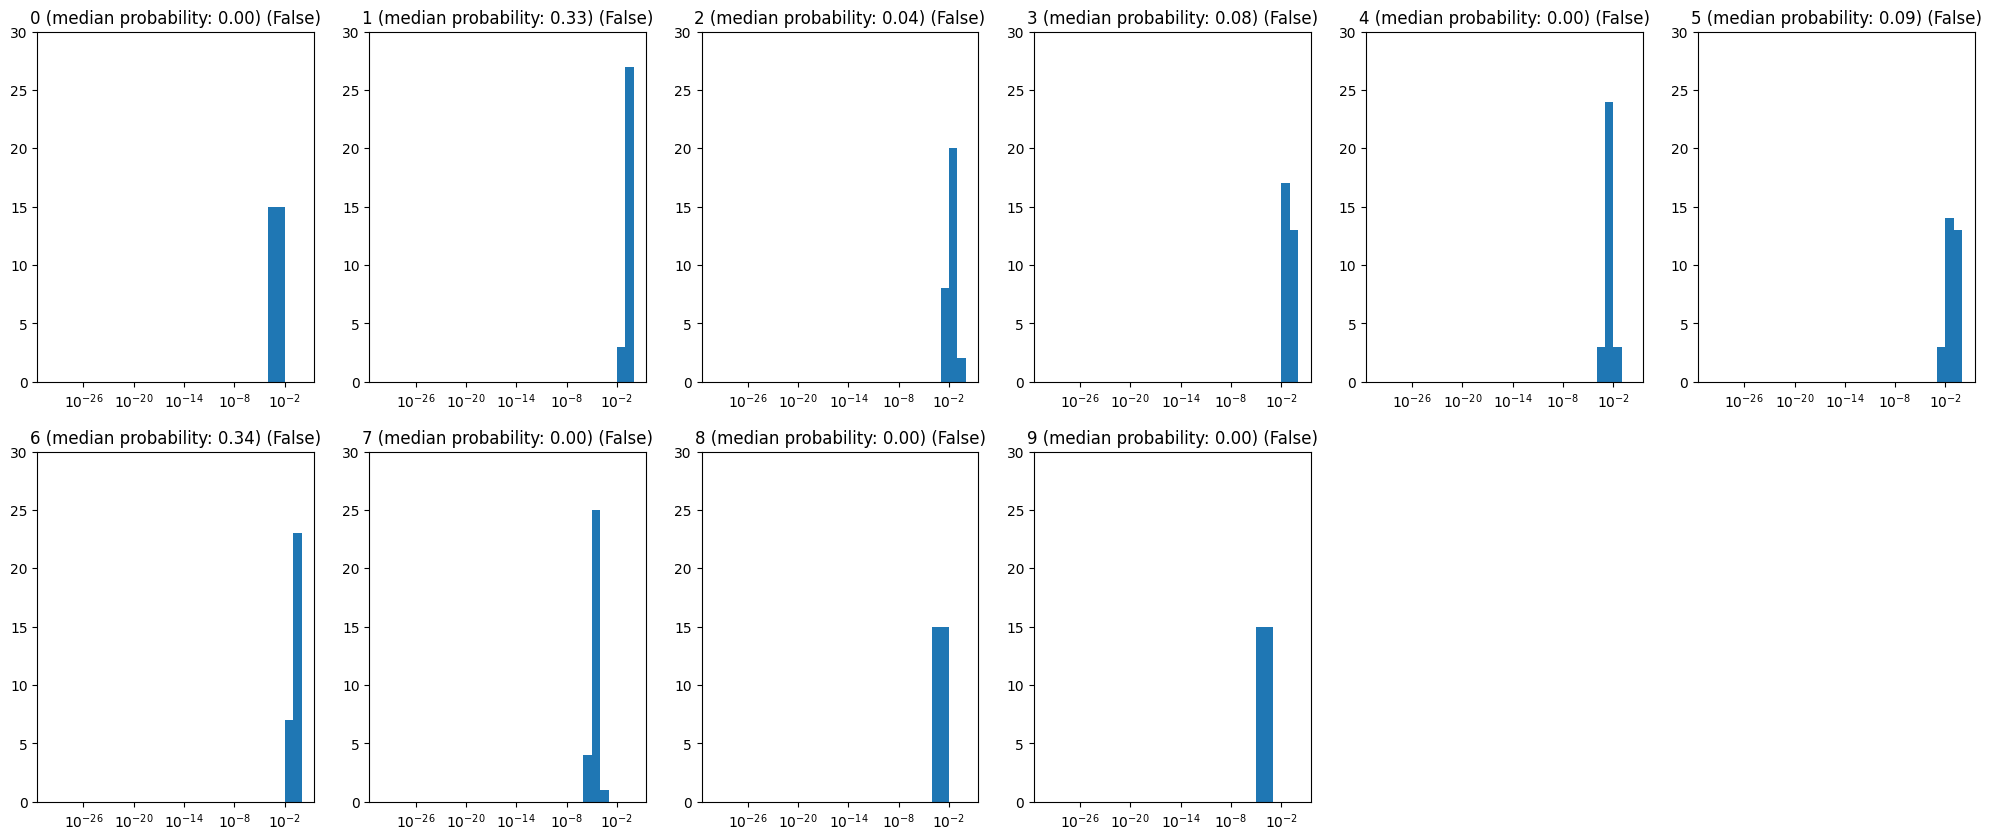

I don't know!
True label of the test sample 1634: 4


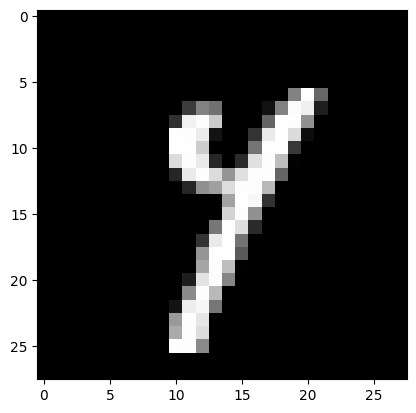

I don't know!
True label of the test sample 1868: 1


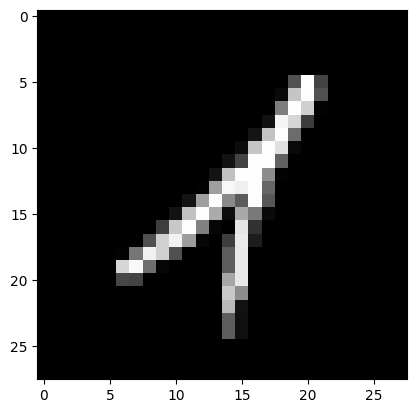

I don't know!
True label of the test sample 1903: 7


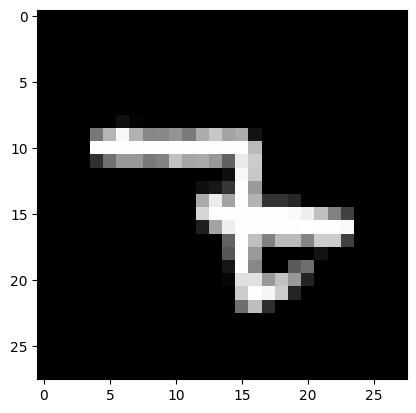

I don't know!
True label of the test sample 2186: 2


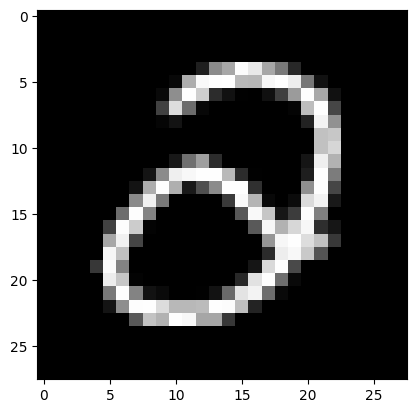

I don't know!
True label of the test sample 2326: 0


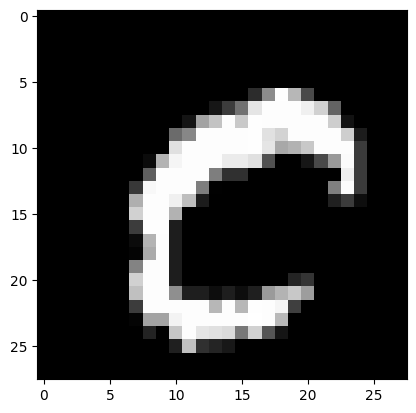

I don't know!
True label of the test sample 2573: 5


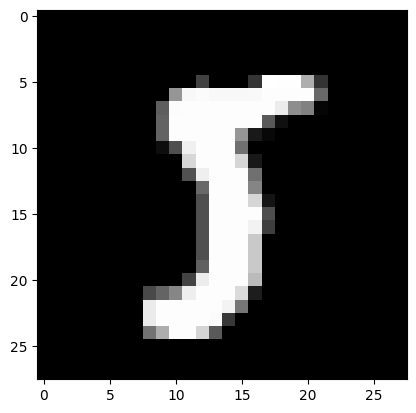

I don't know!
True label of the test sample 2995: 6


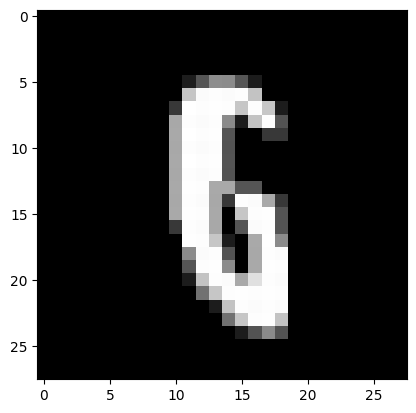

I don't know!
True label of the test sample 3005: 9


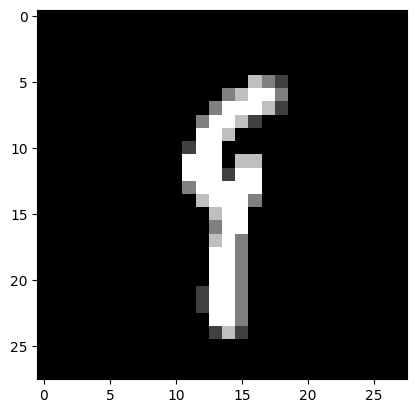

I don't know!
True label of the test sample 3030: 6


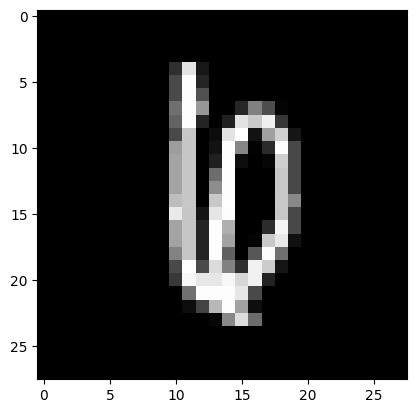

I don't know!
True label of the test sample 3778: 5


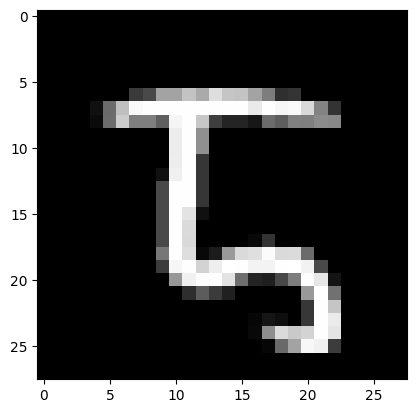

I don't know!
True label of the test sample 3853: 6


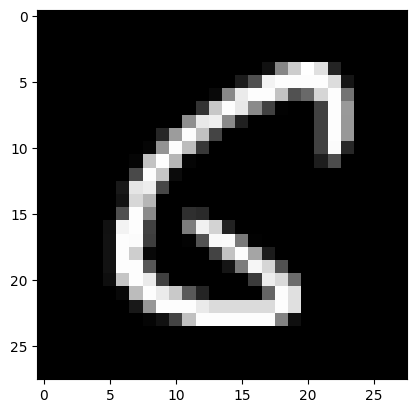

I don't know!
True label of the test sample 4248: 2


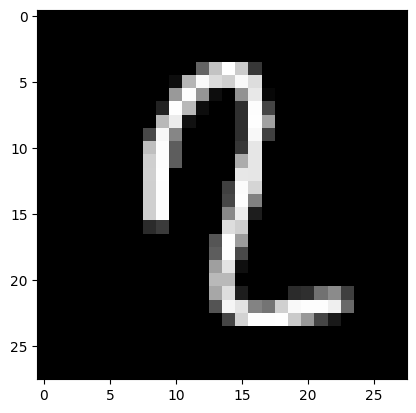

I don't know!
True label of the test sample 4317: 3


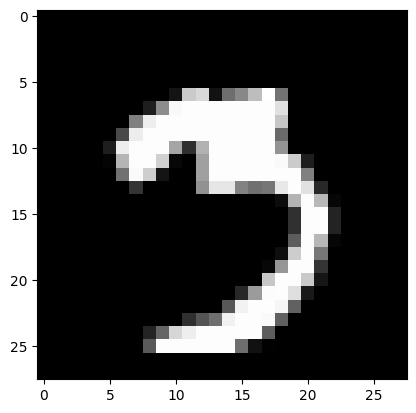

I don't know!
True label of the test sample 5997: 5


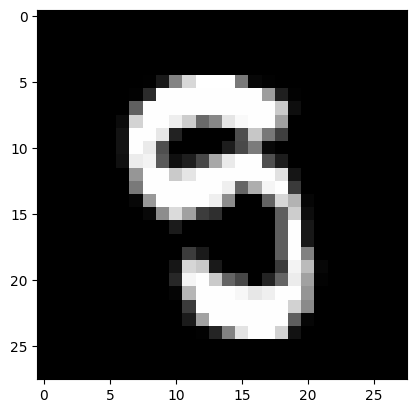

I don't know!
True label of the test sample 6059: 3


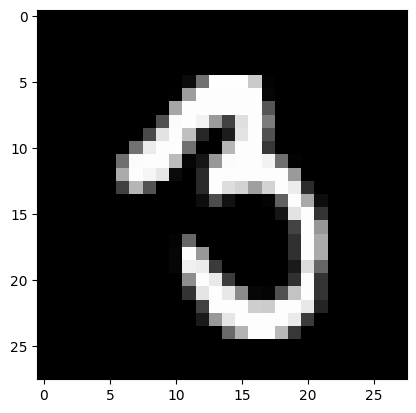

I don't know!
True label of the test sample 6091: 9


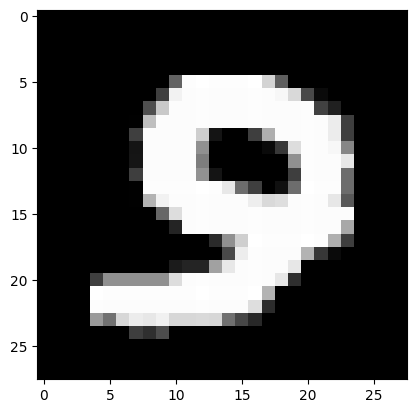

I don't know!
True label of the test sample 9540: 1


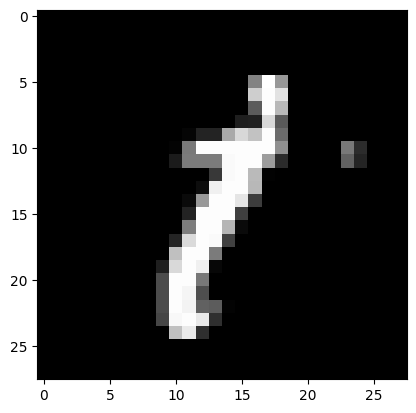

I don't know!
True label of the test sample 9679: 6


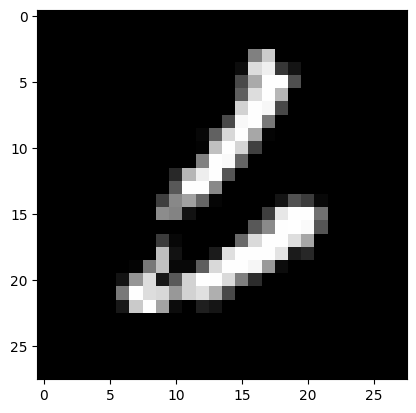

I don't know!
True label of the test sample 9811: 2


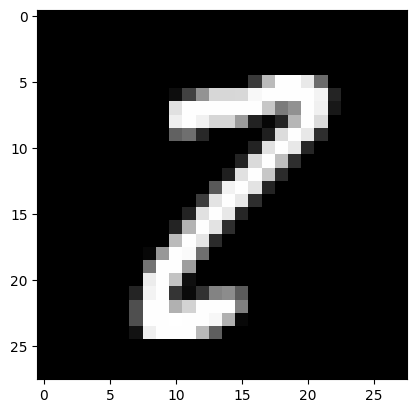

I don't know!


In [65]:
class_nmr = 10
invalids = 0
for idx in np.where(idx_invalid)[0]:
    plt.imshow(test_dataset.data[idx, :, :], cmap='gist_gray')
    print("True label of the test sample {}: {}".format(idx, Y_val[idx]))

    plt.show()

    if idx == 1527:
        plt.savefig('G:/Mi unidad/Tesis doctoral/Transformers/Image Classification/number.svg')

        plot_pred_hist(y_pred_prob_all[idx], class_nmr, n_mc_run, med_prob_thres=med_prob_thres)
        plt.tight_layout()
        plt.savefig('G:/Mi unidad/Tesis doctoral/Transformers/Image Classification/histogram.svg')
        plt.show()

    if any(y_pred[idx]):
        print("Predicted label of the test sample {}: {}".format(idx, np.argmax(y_pred[idx], axis=-1)))
    else:
        print("I don't know!")
    invalids += 1
